In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import PMF
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready.xlsx")

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,Age,Grading,Histology,Type,Status,MonthSurvive,YearSurvive
1,17.0,9.0,Undifferentiated,type_2,1.0,1,1
2,55.0,9.0,Serous carcinoma,type_2,1.0,0,1
3,68.0,9.0,Non-specific,Non-specific,1.0,0,1
4,66.0,9.0,Clear cell carcinoma,type_1,1.0,0,1
5,72.0,9.0,Serous carcinoma,type_2,1.0,0,1


In [6]:
# Feature transformers

cols_standardize = ['Age']
cols_onehotencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

#encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + onehot_encoded)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [8]:
# label transformer

num_durations = 10
labtrans = PMF.label_transform(num_durations)
get_target = lambda df: (df['YearSurvive'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [9]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [10]:
# Neural Net

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [12]:
# model training

model = PMF(net, tt.optim.Adam, duration_index=labtrans.cuts)

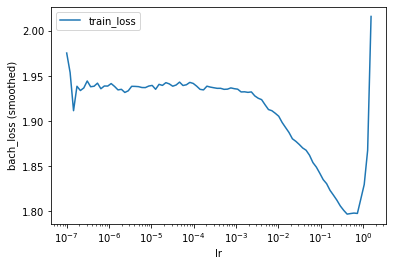

In [13]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=4)
_ = lr_finder.plot()

In [14]:
lr_finder.get_best_lr()

0.04229242874389523

In [15]:
model.optimizer.set_lr(0.01)

In [16]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.8384,	val_loss: 1.7840
1:	[0s / 0s],		train_loss: 1.6853,	val_loss: 1.7076
2:	[0s / 0s],		train_loss: 1.6266,	val_loss: 1.6686
3:	[0s / 0s],		train_loss: 1.5832,	val_loss: 1.6405
4:	[0s / 0s],		train_loss: 1.5579,	val_loss: 1.6159
5:	[0s / 0s],		train_loss: 1.5443,	val_loss: 1.6033
6:	[0s / 0s],		train_loss: 1.5211,	val_loss: 1.5817
7:	[0s / 0s],		train_loss: 1.5002,	val_loss: 1.5677
8:	[0s / 0s],		train_loss: 1.4877,	val_loss: 1.5656
9:	[0s / 0s],		train_loss: 1.4783,	val_loss: 1.5534
10:	[0s / 0s],		train_loss: 1.4651,	val_loss: 1.5446
11:	[0s / 0s],		train_loss: 1.4587,	val_loss: 1.5458
12:	[0s / 0s],		train_loss: 1.4497,	val_loss: 1.5432
13:	[0s / 0s],		train_loss: 1.4414,	val_loss: 1.5403
14:	[0s / 0s],		train_loss: 1.4322,	val_loss: 1.5447
15:	[0s / 0s],		train_loss: 1.4224,	val_loss: 1.5402
16:	[0s / 0s],		train_loss: 1.4241,	val_loss: 1.5416
17:	[0s / 0s],		train_loss: 1.4153,	val_loss: 1.5457
18:	[0s / 0s],		train_loss: 1.4230,	val_loss: 1.5438
19:

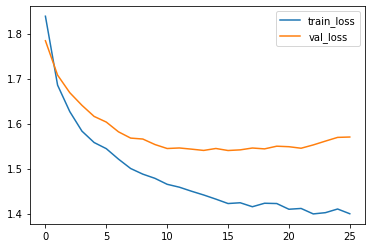

In [17]:
_ = log.plot()

In [18]:
# prediction

surv = model.predict_surv_df(x_test)

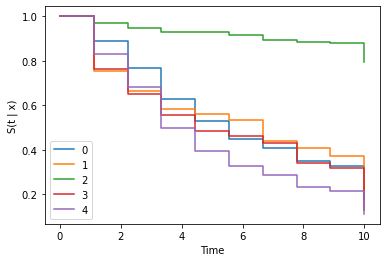

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
surv = model.interpolate(10).predict_surv_df(x_test)

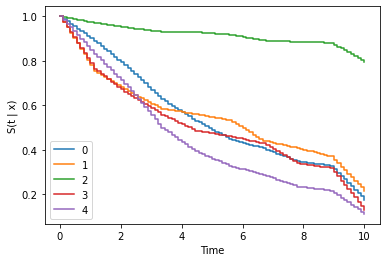

In [21]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [22]:
# evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [23]:
ev.concordance_td('antolini')

0.6645741870120583

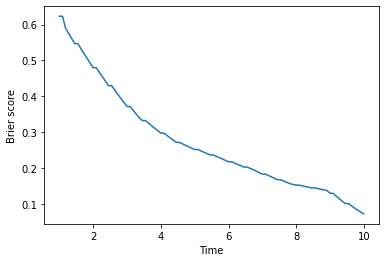

In [24]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

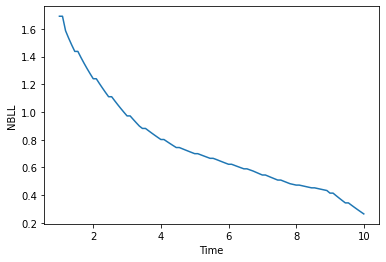

In [25]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [26]:
ev.integrated_brier_score(time_grid) 

0.2711975597859835

In [27]:
ev.integrated_nbll(time_grid) 

0.7508506866877753